<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 9.6: Sentiment Analysis
INSTRUCTIONS:
- Run the cells
- Observe and understand the results
- Answer the questions

Based on the video tutorial **Text Classification with Machine Learning,SpaCy and Scikit(Sentiment Analysis)** by **Jesse E. Agbe (JCharis)**.

## Data Source: UCI
### UCI - Machine Learning Repository
- Center for Machine Learning and Intelligent Systems

The [**UCI Machine Learning Repository**](http://archive.ics.uci.edu/ml/about.html) is a collection of databases, domain theories, and data generators that are used by the machine learning community for the empirical analysis of machine learning algorithms.

### Dataset
- [Sentiment Labelled Sentences Data Set](http://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences)

### Abstract
The dataset contains sentences labelled with positive or negative sentiment.

- Data Set Characteristics: Text
- Number of Instances: 3000
- Area: N/A
- Attribute Characteristics: N/A
- Number of Attributes: N/A
- Date Donated: 2015-05-30
- Associated Tasks: Classification
- Missing Values? N/A
- Number of Web Hits: 102584

### Source
Dimitrios Kotzias dkotzias '@' ics.uci.edu

### Data Set Information
This dataset was created for the Paper 'From Group to Individual Labels using Deep Features', Kotzias et. al,. KDD 2015

Please cite the paper if you want to use it :)

It contains sentences labelled with positive or negative sentiment.

### Format
sentence &lt;tab&gt; score &lt;newline&gt;

### Details
Score is either 1 (for positive) or 0 (for negative)

The sentences come from three different websites/fields:
- imdb.com
- amazon.com
- yelp.com

For each website, there exist **500 positive** and **500 negative** sentences. Those were selected randomly for larger datasets of reviews.

We attempted to select sentences that have a clearly positive or negative connotaton, the goal was for no neutral sentences to be selected.

For the full datasets look:

- **imdb**: Maas et. al., 2011 _Learning word vectors for sentiment analysis_
- **amazon**: McAuley et. al., 2013 _Hidden factors and hidden topics: Understanding rating dimensions with review text_
- **yelp**: [Yelp dataset challenge](http://www.yelp.com/dataset_challenge)


### Attribute Information
The attributes are text sentences, extracted from reviews of products, movies, and restaurants

### Relevant Papers
**From Group to Individual Labels using Deep Features**, Kotzias et. al,. KDD 2015

### Citation Request
**From Group to Individual Labels using Deep Features**, Kotzias et. al,. KDD 2015

## Import libraries

In [1]:
## Import Libraries
import pandas as pd

import regex as re
import spacy

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import warnings
warnings.filterwarnings('ignore')

## Load data

Load Yelp, Amazon and Imdb Data.

Hint: Source is separated by <tab>s and has no headers.

In [7]:
yelp_text = pd.read_csv('yelp_labelled.txt', header=None, sep='\t')
imdb_text = pd.read_csv('imdb_labelled.txt', header=None, sep='\t')
amazon_text = pd.read_csv('amazon_cells_labelled.txt', header=None, sep='\t')

# ANSWER
amazon_text

,0,1
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
995,The screen does get smudged easily because it ...,0
996,What a piece of junk.. I lose more calls on th...,0
997,Item Does Not Match Picture.,0
998,The only thing that disappoint me is the infra...,0


## Inspect the data

Check your datasets.

In [11]:
df_list = {'yelp': yelp_text, 'imdb': imdb_text, 'amazon': amazon_text}
# ANSWER
# - assign column names
# - add the data source
# - check the data
for ds in df_list.keys():
    print('Dataset: %s [%d row(s) x %d col(s)]' % (ds, df_list[ds].shape[0], df_list[ds].shape[1]))
    df_list[ds].columns = ['text', 'sentiment']
    df_list[ds]['source'] = ds
    print(df_list[ds].head())
    print('-' * 75)

Dataset: yelp [1000 row(s) x 2 col(s)]
                                                text  sentiment source
0                           Wow... Loved this place.          1   yelp
1                                 Crust is not good.          0   yelp
2          Not tasty and the texture was just nasty.          0   yelp
3  Stopped by during the late May bank holiday of...          1   yelp
4  The selection on the menu was great and so wer...          1   yelp
---------------------------------------------------------------------------
Dataset: imdb [748 row(s) x 2 col(s)]
                                                text  sentiment source
0  A very, very, very slow-moving, aimless movie ...          0   imdb
1  Not sure who was more lost - the flat characte...          0   imdb
2  Attempting artiness with black & white and cle...          0   imdb
3       Very little music or anything to speak of.            0   imdb
4  The best scene in the movie was when Gerardo i...          1   

## Merge the data

Merge all three datasets.

In [13]:
# ANSWER
df = pd.concat(df_list.values(), ignore_index = True)

## Export the data

Export merged datasets to as csv file.

In [14]:
# ANSWER
df.to_csv('merged_sentiment_df.csv', index = None)

## Prepare the stage
- Load spaCy

In [16]:
nlp = spacy.load('en_core_web_sm')

## Prepare the text
All the text handling and preparation concerned with the changes and modifications from the raw source text to a format that will be used for the actual processing, things like:
- handle encoding
- handle extraneous and international charaters
- handle simbols
- handle metadata and embeded information
- handle repetitions (such multiple spaces or newlines)

Clean text.

In [17]:
def clean_text(text):
    # reduce multiple spaces and newlines to only one
    text = re.sub(r'(\s\s+|\n\n+)', r'\1', text)
    # remove double quotes
    text = re.sub(r'"', '', text)

    return text

In [18]:
# ANSWER
df['text'] = df['text'].apply(clean_text)

In [19]:
df

,text,sentiment,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp
...,...,...,...
2743,The screen does get smudged easily because it ...,0,amazon
2744,What a piece of junk.. I lose more calls on th...,0,amazon
2745,Item Does Not Match Picture.,0,amazon
2746,The only thing that disappoint me is the infra...,0,amazon


## Work the text
Concern with the meaning and the substance of the content to extract actual information.

Hint: Use techniques learned in previous labs. Remove StopWords, Punctuation, Lemmatize etc.

In [20]:
def convert_text(text):
    sent = nlp(text)
    ents = {x.text: x for x in sent.ents}
    tokens = []
    for w in sent:
        if w.is_stop or w.is_punct or w.is_digit:
            continue
        if w.text in ents:
            tokens.append(w.text)
        else:
            tokens.append(w.lemma_.lower())
    text = ' '.join(tokens)

    return text

In [21]:
%%time
df['short'] = df['text'].apply(convert_text)

CPU times: user 24.1 s, sys: 692 ms, total: 24.8 s
Wall time: 25.3 s


In [22]:
df.sample(10)

,text,sentiment,source,short
975,What happened next was pretty....off putting.,0,yelp,happen pretty put
579,"As for the service: I'm a fan, because it's qu...",1,yelp,service fan quick serve nice folk
1608,The worst one of the series.,0,imdb,bad series
2512,wont work right or atleast for me.,0,amazon,wo nt work right atleast
1979,What a big waste of time.,0,amazon,big waste time
226,This is an unbelievable BARGAIN!,1,yelp,unbelievable bargain
2314,Cumbersome design.,0,amazon,cumbersome design
2030,"First of all, it doesn't wear well.",0,amazon,wear
562,A good time!,1,yelp,good time
2304,Great product for the price!.,1,amazon,great product price


## Modelling

In [23]:
# helper function to show results and charts
def show_summary_report(actual, prediction, probabilities):
    
    # If actual labels is a Series, extract the array
    if isinstance(actual, pd.Series):
        actual = actual.values
    # If actual and/or prediction labels are strings, convert to integers
    if actual.dtype.name == 'object':
        actual = actual.astype(int)
    if prediction.dtype.name == 'object':
        prediction = prediction.astype(int)
        
    # Calculate model evaluation metrics
    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction)
    recall_ = recall_score(actual, prediction)
    roc_auc_ = roc_auc_score(actual, prediction)

    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, prediction)
    average_precision = average_precision_score(actual, prediction)
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, probabilities)
    roc_auc = auc(fpr, tpr)

    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Plot Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax[0])

    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')
    
    # Plot Precision/Recall curve
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # Plot ROC curve
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')

    plt.show()
    
    return (accuracy_, precision_, recall_, roc_auc_)

In [24]:
# Features and Labels
X = df['short']
y = df['sentiment']

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Use Bag-of-Words

In [25]:
# create a matrix of word counts from the text
counts = CountVectorizer()

In [26]:
# do the actual counting
A = counts.fit_transform(X_train, y_train)

In [27]:
# create a classifier using SVC
classifier = SVC(kernel='linear', probability=True)

In [28]:
# train the classifier with the training data
classifier.fit(A.toarray(), y_train)

SVC(kernel='linear', probability=True)

In [29]:
# do the transformation for the test data
# NOTE: use `transform()` instead of `fit_transform()`
B = counts.transform(X_test)

In [31]:
# make predictions based on the test data
predictions = classifier.predict(B.todense())

# store probabilities of predictions being 1
probabilities = classifier.predict_proba(B.todense())[:, 1]

In [32]:
# check the accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, predictions))

Accuracy: 0.7727


## Repeat using TF-IDF
TF-IDF = Term Frequency - Inverse Document Frequency

In [33]:
# create a matrix of word counts from the text
# use TF-IDF
tfidf = TfidfVectorizer()
# do the actual counting
A = tfidf.fit_transform(X_train, y_train)

# train the classifier with the training data
classifier.fit(A.toarray(), y_train)

# do the transformation for the test data
# NOTE: use `transform()` instead of `fit_transform()`
B = tfidf.transform(X_test)

# make predictions based on the test data
predictions = classifier.predict(B.todense())

# store probabilities of predictions being 1
probabilities = classifier.predict_proba(B.todense())[:, 1]

# check the accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, predictions))

Accuracy: 0.7727


## Repeating it all for comparision
Repeating the whole lot in one big block

Find 'Accuracy', 'Precision', 'Recall', 'ROC_AUC' using CountVectorizer and TfidfVectorizer and keep the result in a dataframe.

*********
* Count *
*********
Accuracy : 0.7727 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7343 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7897 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7740                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


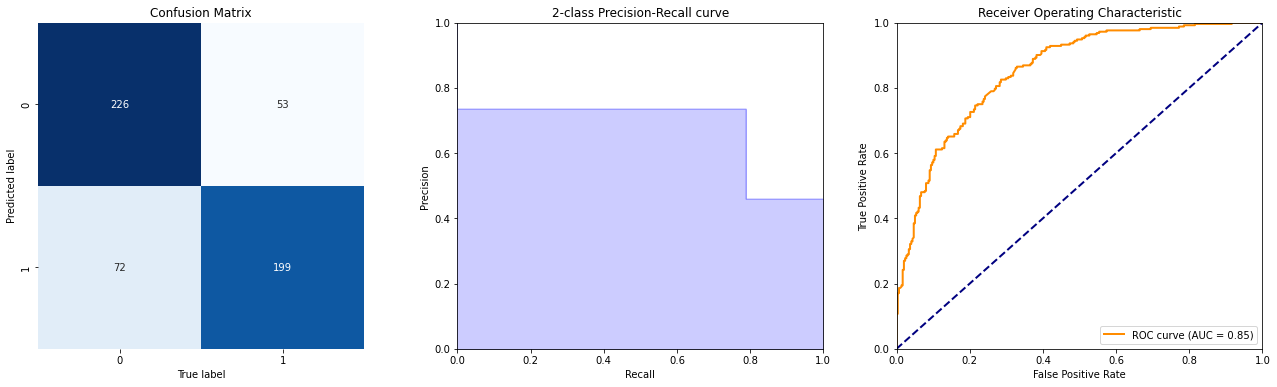

**********
* TF-IDX *
**********
Accuracy : 0.7727 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7276 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8056 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7753                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


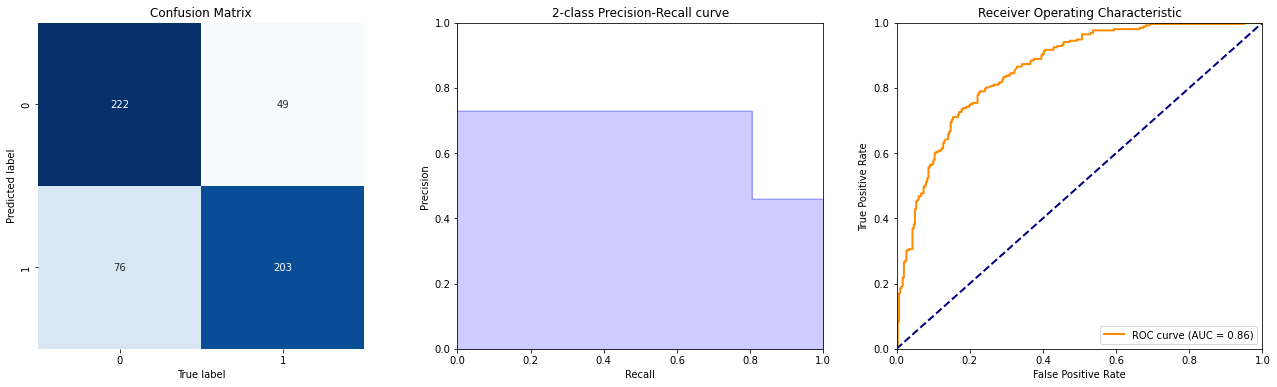

In [34]:
# ANSWER
# Keep the results in a dataframe
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])

models = ['Count', 'TF-IDX']
for i, m in enumerate([CountVectorizer(), TfidfVectorizer()]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    
    # create a matrix of word counts from the text
    # use TF-IDF
    counts = m
    # do the actual counting
    A = counts.fit_transform(X_train, y_train)

    # create a classifier using SVC
    classifier = SVC(kernel='linear', probability=True)

    # train the classifier with the training data
    classifier.fit(A.toarray(), y_train)

    # do the transformation for the test data
    # NOTE: use `transform()` instead of `fit_transform()`
    B = counts.transform(X_test)

    # make predictions based on the test data
    predictions = classifier.predict(B.todense())

    # store probabilities of predictions being 1
    probabilities = classifier.predict_proba(B.todense())[:, 1]

    # show the report
    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_test, predictions, probabilities)
    # keep the results
    results.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_, 
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}



---



---



> > > > > > > > > © 2021 Institute of Data


---



---



